<a href="https://colab.research.google.com/github/putrimaharani355/Expression-Classification/blob/main/CNN_ML_Tubes_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install split-folders

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.metrics import classification_report
import splitfolders
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input, Conv1D, MaxPool1D ,Conv2D, MaxPooling2D
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from keras import regularizers
from keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.models import Sequential, Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import zipfile

local_zip = '/content/drive/MyDrive/Expression/Expression(2).zip'
zip_ref = zipfile.ZipFile(local_zip, 'r') # Membaca local path
zip_ref.extractall('/tmp') # Extract .zip file
zip_ref.close()

In [ ]:
#splitting
splitfolders.ratio('/tmp/Expression', output="tmp/expression_split", seed=1337, ratio=(.7, 0.25,0.05))

Copying files: 35887 files [00:15, 2301.37 files/s]


In [ ]:
# Definisikan path untuk data train dan data validation

base_dir = '/content/tmp/expression_split'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

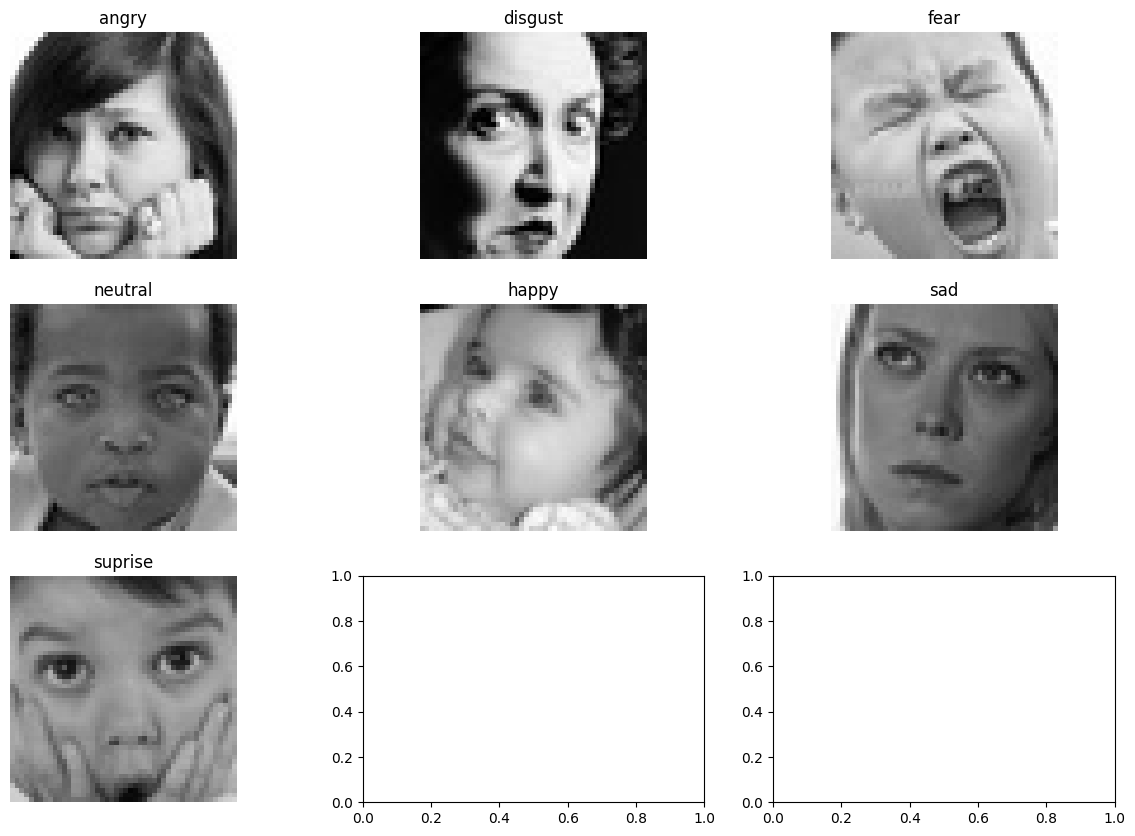

In [ ]:
import random
from tensorflow.keras.preprocessing.image import load_img

# Membuat plot dengan dua kolom subplot yang berada dalam satu baris
fig, ax = plt.subplots(3, 3, figsize=(15, 10)) # figsize() untuk set ukurang gambar

sample_angry = random.choice(os.listdir(train_dir + "/angry")) # library random digunakan untuk memilih data secara acak
image = load_img(train_dir + "/angry/" + sample_angry) # library load_img digunakan untuk memuat gambar dengan path yang sudah ditentukan
# set gambar untuk kolom pertama (index 0)
ax[0][0].imshow(image)
ax[0][0].set_title("angry")
ax[0][0].axis("Off")

sample_disgust = random.choice(os.listdir(train_dir + "/disgust"))
image = load_img(train_dir + "/disgust/" + sample_disgust)
# set gambar untuk kolom kedua (index 1)
ax[0][1].imshow(image)
ax[0][1].set_title("disgust")
ax[0][1].axis("Off")

sample_fear = random.choice(os.listdir(train_dir + "/fear"))
image = load_img(train_dir + "/fear/" + sample_fear)
# set gambar untuk kolom kedua (index 1)
ax[0][2].imshow(image)
ax[0][2].set_title("fear")
ax[0][2].axis("Off")

sample_neutral = random.choice(os.listdir(train_dir + "/neutral"))
image = load_img(train_dir + "/neutral/" + sample_neutral)
# set gambar untuk kolom kedua (index 1)
ax[1][0].imshow(image)
ax[1][0].set_title("neutral")
ax[1][0].axis("Off")

sample_happy = random.choice(os.listdir(train_dir + "/happy"))
image = load_img(train_dir + "/happy/" + sample_happy)
# set gambar untuk kolom kedua (index 1)
ax[1][1].imshow(image)
ax[1][1].set_title("happy")
ax[1][1].axis("Off")

sample_sad = random.choice(os.listdir(train_dir + "/sad"))
image = load_img(train_dir + "/sad/" + sample_sad)
# set gambar untuk kolom kedua (index 1)
ax[1][2].imshow(image)
ax[1][2].set_title("sad")
ax[1][2].axis("Off")

sample_suprise = random.choice(os.listdir(train_dir + "/surprise"))
image = load_img(train_dir + "/surprise/" + sample_suprise)
# set gambar untuk kolom kedua (index 1)
ax[2][0].imshow(image)
ax[2][0].set_title("suprise")
ax[2][0].axis("Off")
plt.show()

In [ ]:
# normalize the scale in every images using ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator

datagen     = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=30,
                    zoom_range=0.2,
                    horizontal_flip=True,
                    shear_range=0.2,               # Menambahkan shear transformation dengan kisaran 20%
                    height_shift_range=0.2,        # Menambahkan pergeseran tinggi dengan kisaran 20%
                    fill_mode='nearest')

# implement ImageDataGenerator in train data
train_gen = datagen.flow_from_directory(train_dir, #Direktori data
                                             target_size=(150, 150), #Target size image
                                             batch_size=32, #Menerapkan batch size
                                             class_mode='binary') #Menerapkan mode kelas

Found 25117 images belonging to 7 classes.


In [ ]:
# Fungsi ini akan memplot gambar dalam bentuk grid dengan 1 baris dan 5 kolom, di mana gambar ditempatkan di setiap kolom.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

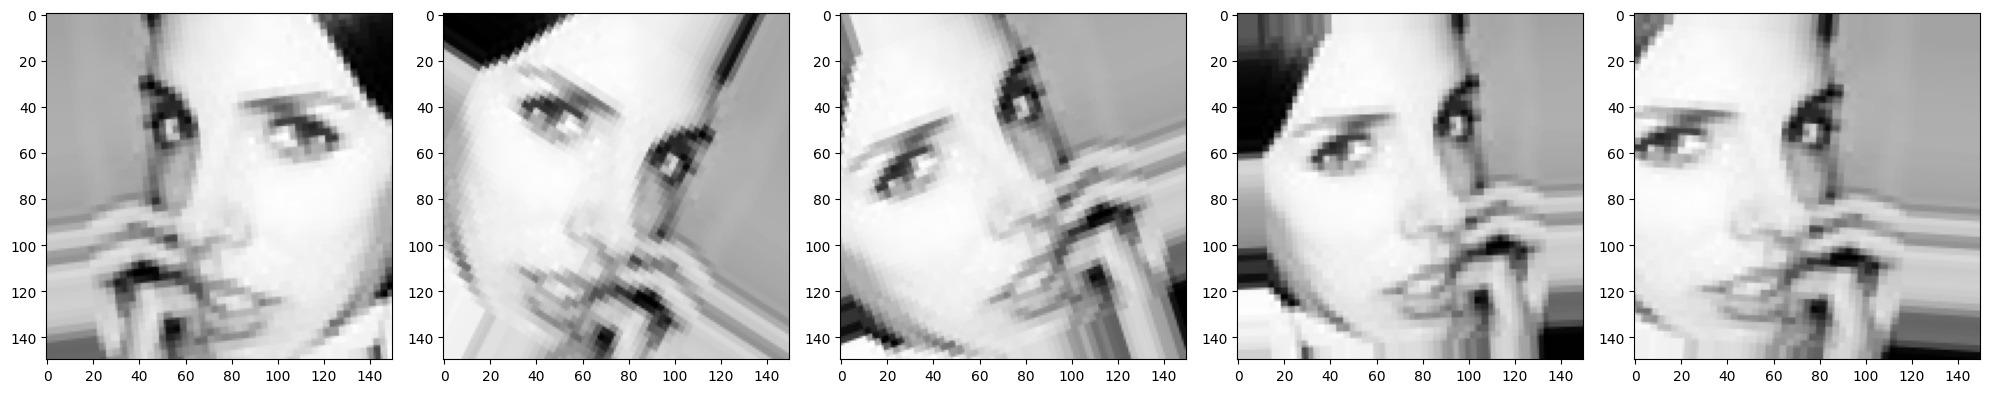

In [ ]:
# Visualisasi Data Train yang sudah di-augmentasi
augmented_images = [train_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.2,
    horizontal_flip=True,
    shear_range=0.2,               # Menambahkan shear transformation dengan kisaran 20%
    height_shift_range=0.2,        # Menambahkan pergeseran tinggi dengan kisaran 20%
    fill_mode='nearest'
    # rescale = 1./255,   ## rescale or normalize the images pixels, by dividing them 255
    # shear_range = 0.2,  ## angle for slant of image in degrees
    # zoom_range = 0.2,   ## for zoom in or out
    # horizontal_flip = True
)
training_set = train_datagen.flow_from_directory(
    '/content/tmp/expression_split/train',   ## give path of training set
    target_size=(48,48),      ## target_size of image in which you want
    batch_size=32,
    class_mode = 'categorical'
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    '/content/tmp/expression_split/val',
    target_size = (48,48),
    batch_size = 32,
    class_mode = 'categorical'
)

Found 25117 images belonging to 7 classes.
Found 8969 images belonging to 7 classes.


In [ ]:
# Define a simple CNN model
model = keras.models.Sequential()

# model.add(keras.layers.Conv2D(32, 3, activation='relu', input_shape=(48, 48, 3)))

# model.add(keras.layers.Dropout(0.1))
# model.add(keras.layers.MaxPooling2D())

# model.add(keras.layers.Conv2D(64, 3, activation='relu'))
# model.add(keras.layers.Dropout(0.15))
# model.add(keras.layers.MaxPooling2D())

# model.add(keras.layers.Flatten())
# model.add(keras.layers.Dense(128, activation='relu'))
# model.add(keras.layers.Dense(7, activation='softmax'))
model.add(Conv2D(64, (3,3), padding='same', input_shape=(48,48,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Conv Block 2
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Conv Block 3
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# # Conv Block 3
# model.add(Conv2D(512,(3,3), padding='same'))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Dropout(0.25))

model.add(Flatten())

# Fully connected Block 1
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected Block 2
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

In [ ]:
# # Compile the model
# model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
learning_rate = 0.005  # Example learning rate, you can adjust this value

# Define the optimizer with the specified learning rate
optimizer = Adam(learning_rate=learning_rate)

# Compile the model with the specified optimizer
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 48, 48, 64)        1792      
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 24, 24, 64)        0         
 ng2D)                                                           
                                                                 
 dropout_10 (Dropout)        (None, 24, 24, 64)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 24, 24, 128)      

In [ ]:
history = model.fit(training_set, epochs=10, validation_data=test_generator)

Epoch 1/10
785/785 [==============================] - 929s 1s/step - loss: 1.7384 - accuracy: 0.2975 - val_loss: 2.1976 - val_accuracy: 0.2151
Epoch 2/10
785/785 [==============================] - 921s 1s/step - loss: 1.6296 - accuracy: 0.3606 - val_loss: 1.6864 - val_accuracy: 0.3401
Epoch 3/10
785/785 [==============================] - 938s 1s/step - loss: 1.5416 - accuracy: 0.3959 - val_loss: 1.7031 - val_accuracy: 0.3004
Epoch 4/10
785/785 [==============================] - 929s 1s/step - loss: 1.4764 - accuracy: 0.4281 - val_loss: 1.4804 - val_accuracy: 0.4271
Epoch 5/10
785/785 [==============================] - 929s 1s/step - loss: 1.4324 - accuracy: 0.4480 - val_loss: 1.5798 - val_accuracy: 0.3324
Epoch 6/10
785/785 [==============================] - 920s 1s/step - loss: 1.3864 - accuracy: 0.4666 - val_loss: 1.2816 - val_accuracy: 0.5023
Epoch 7/10
785/785 [==============================] - 905s 1s/step - loss: 1.3585 - accuracy: 0.4780 - val_loss: 1.2633 - val_accuracy: 0.5300

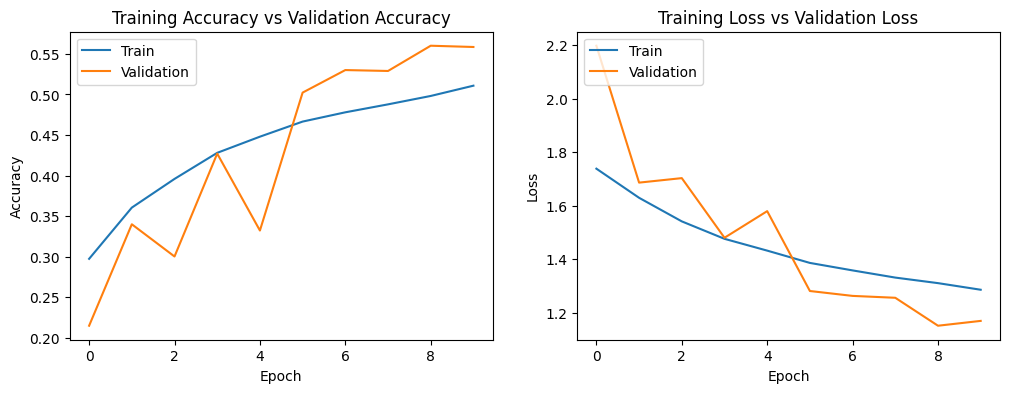

In [ ]:
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()